In [5]:
tasks = ["capitalization", "country_capital", "present_past"]
corrupted_examples = [
    "corrupt_query",
    "corrupt_everything", "corrupt_both", "corrupt_sep", "separable_gemma"]

In [7]:
import numpy as np
imp_scores_dct = {}
for task in tasks:
    for tp_of_corrupted_examples in corrupted_examples:
        imp_scores_dct[(task, tp_of_corrupted_examples)] = np.load(paths_to_imp_scores[task + "_" + tp_of_corrupted_examples])

In [248]:
import json
accuracies = {}
threses = [14, 29, 43, 58, 72, 87, 101, 116, 131, 145, 160, 174, 189, 203, 218, 232, 247, 262, 276, 291, 305, 320, 334, 349, 364, 378, 393, 407, 422, 436, 451, 465, 480, 495, 509, 524, 538, 553, 567, 582] + [145, 291, 436, 582, 728, 873, 1019, 1164, 1310, 1456]
path = "/proj/inductive-bias/llama/patching_llama/sasha-outputs/prune-by-head-imp-scores"
for task in tasks:
    for corrupted_example in corrupted_examples:
        for k in threses:
            full_path = path + f"/{task}_{corrupted_example}/prune-k-{k}/logging_dir/model_logs.json"
            try:
                with open(full_path, "r") as file:
                    acc = json.load(file)["accuracy"]
                accuracies[(task, corrupted_example, k)] = acc
            except:
                continue

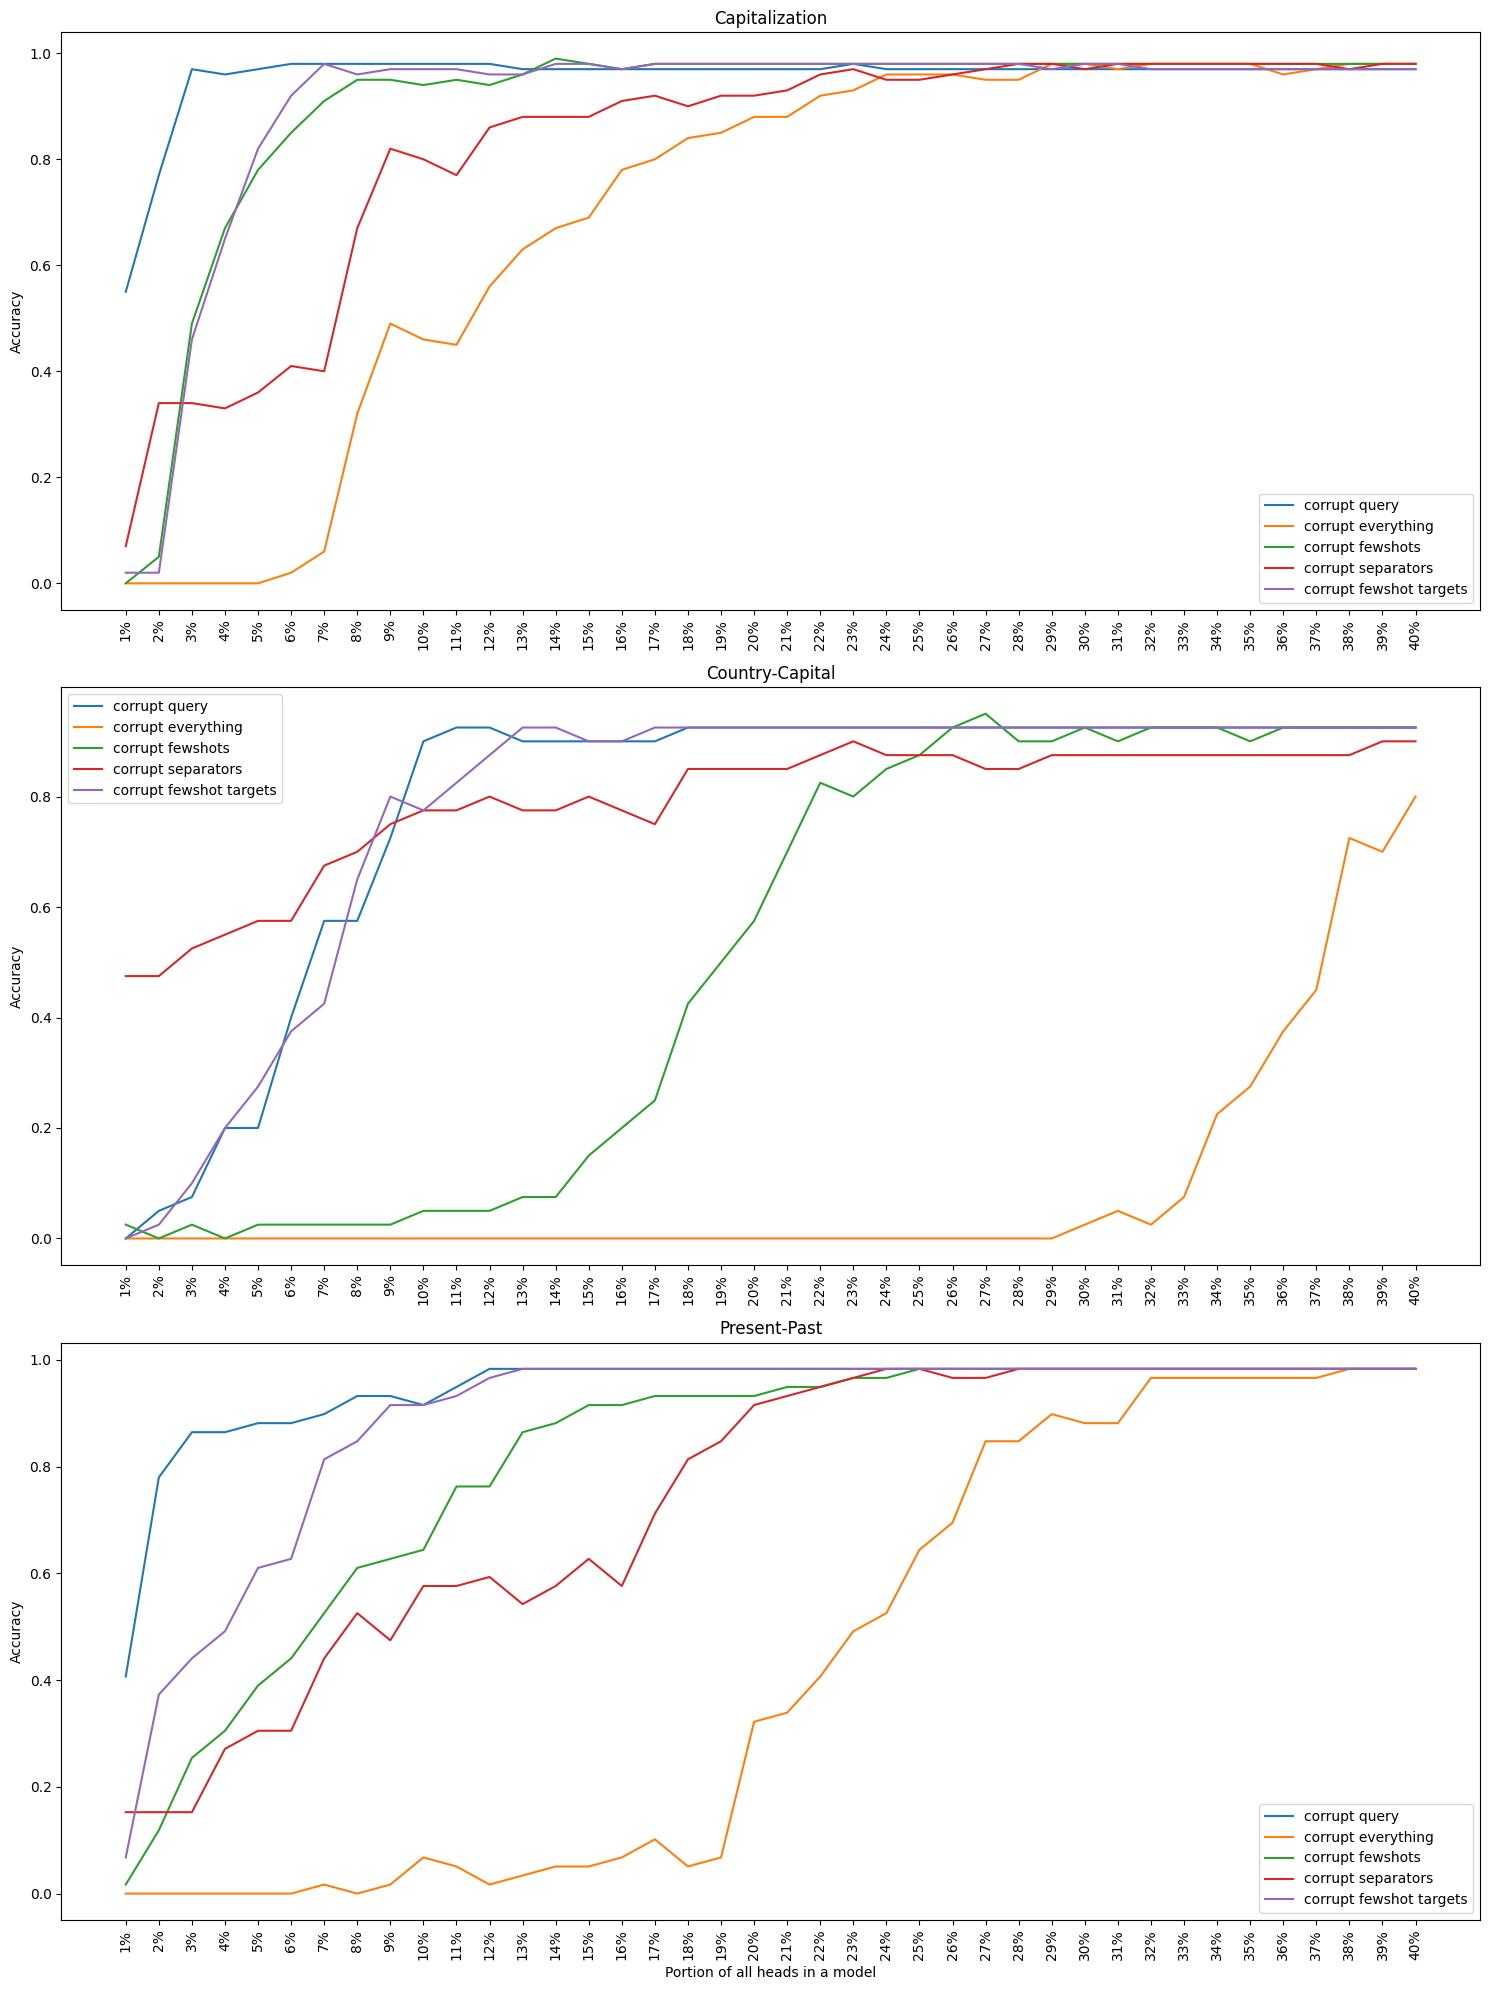

In [253]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1)
fig.set_size_inches((15, 20))
corrupted_example_to_label = {
    "corrupt_query" : "corrupt query",
    "corrupt_everything": "corrupt everything",
    "corrupt_both": "corrupt fewshots",
    "corrupt_sep": "corrupt separators",
    "separable_gemma": "corrupt fewshot targets"

}

threses = [14, 29, 43, 58, 72, 87, 101, 116, 131, 145, 160, 174, 189, 203, 218, 232, 247, 262, 276, 291, 305, 320, 334, 349, 364, 378, 393, 407, 422, 436, 451, 465, 480, 495, 509, 524, 538, 553, 567, 582] # [728, 873, 1019, 1164, 1310, 1456]
for task_i, task in enumerate(tasks):
    for corrupted_example in corrupted_examples:
        to_plot = []
        for k in threses:
            to_plot.append(accuracies[(task, corrupted_example, k)])
        axs[task_i].plot(to_plot, label=corrupted_example_to_label[corrupted_example])
    axs[task_i].legend()
    axs[task_i].set_xticks(np.arange(len(threses)), [f"{k}%" for k in range(1, len(threses) + 1)])
    axs[task_i].tick_params(axis='x', rotation=90)
    axs[task_i].set_title("-".join([word.capitalize() for word in task.split("_")]))
    axs[task_i].set_ylabel("Accuracy")
axs[2].set_xlabel("Portion of all heads in a model")
fig.tight_layout()
plt.savefig("accuracy.png")

In [207]:
imp_heads_list = {}
for task in tasks:
    for tp_of_corrupted_examples in corrupted_examples:
        imp_heads_list[(task, tp_of_corrupted_examples)] = [(-imp_scores_dct[(task, tp_of_corrupted_examples)][l, h, tp], l, h, tp) for l in range(26) for h in range(8) for tp in range(7)]
sorted_imp_heads_list = {t: sorted(imp_heads_list[t]) for t in imp_heads_list}
threses = [14, 29, 43, 58, 72, 87, 101, 116, 131, 145, 160, 174, 189, 203, 218, 232, 247, 262, 276, 291, 305, 320, 334, 349, 364, 378, 393, 407, 422, 436, 451, 465, 480, 495, 509, 524, 538, 553, 567, 582] + [145, 291, 436, 582, 728, 873, 1019, 1164, 1310, 1456]
heads_in_imp_heads_subset = {}
for thres in threses:
    for t in sorted_imp_heads_list:
        heads_in_imp_heads_subset[(t, thres)] = set([(h[1], h[2], h[3]) for h in sorted_imp_heads_list[t][:thres]])

In [244]:
import json
threses = [14, 29, 43, 58, 72, 87, 101, 116, 131, 145, 160, 174, 189, 203, 218, 232, 247, 262, 276, 291, 305, 320, 334, 349, 364, 378, 393, 407, 422, 436, 451, 465, 480, 495, 509, 524, 538, 553, 567, 582] + [145, 291, 436, 582, 728, 873, 1019, 1164, 1310, 1456]
threses_with_good_acc = {}
for task in tasks:
    for corrupted_example in corrupted_examples:
        threses_with_good_acc[(task, corrupted_example)] = None
        for k in threses:
            try:
                if accuracies[(task, corrupted_example, k)] >= accuracies[(task, corrupted_example, 1456)]:
                    threses_with_good_acc[(task, corrupted_example)] = k
                    break
            except:
                break

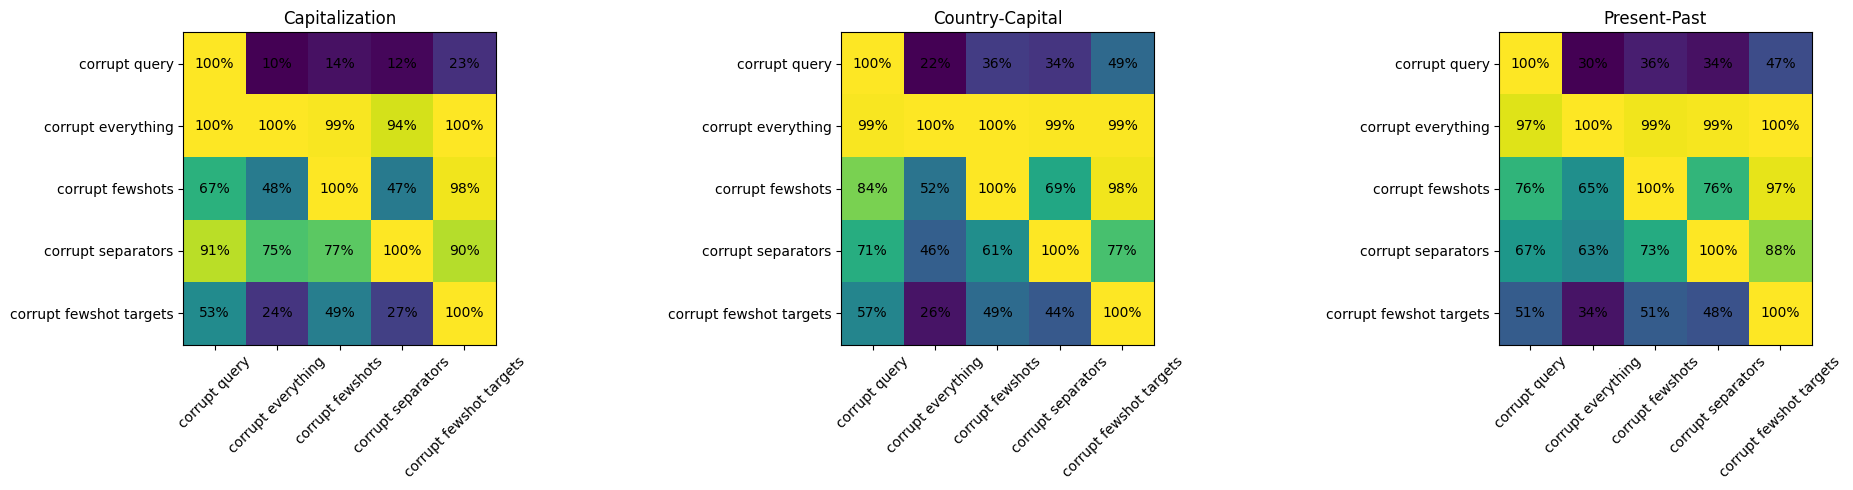

In [246]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3)
fig.set_size_inches((20, 5))
corrupted_example_to_label = {
    "corrupt_query" : "corrupt query",
    "corrupt_everything": "corrupt everything",
    "corrupt_both": "corrupt fewshots",
    "corrupt_sep": "corrupt separators",
    "separable_gemma": "corrupt fewshot targets"

}

for task_i, task in enumerate(tasks):
    intersections = np.zeros((len(corrupted_examples), len(corrupted_examples)))
    for i, corrupted_example in enumerate(corrupted_examples):
        for j, corrupted_example_2 in enumerate(corrupted_examples):
            intersections[i, j] = len(heads_in_imp_heads_subset[((task, corrupted_example), threses_with_good_acc[(task, corrupted_example)])].intersection(
                heads_in_imp_heads_subset[((task, corrupted_example_2), threses_with_good_acc[(task, corrupted_example_2)])]))
            intersections[i, j] = intersections[i, j] / threses_with_good_acc[(task, corrupted_example_2)]

    axs[task_i].imshow(intersections)
    axs[task_i].set_xticks(np.arange(len(corrupted_examples)), [corrupted_example_to_label[ex] for ex in corrupted_examples])
    axs[task_i].set_yticks(np.arange(len(corrupted_examples)), [corrupted_example_to_label[ex] for ex in corrupted_examples])
    for i, corrupted_example in enumerate(corrupted_examples):
        for j in range(len(corrupted_examples)):
            text = axs[task_i].text(j, i, f"{intersections[i, j] * 100:.0f}%",
                        ha="center", va="center", color="black")
    axs[task_i].tick_params(axis='x', rotation=45)
    axs[task_i].set_title("-".join([word.capitalize() for word in task.split("_")]))
fig.tight_layout()
# plt.savefig("images/head_overlap_05.png")

In [227]:
tps = {task: np.zeros((len(corrupted_examples), 7), dtype=int)
       for task_i, task in enumerate(tasks)}
layers = {task: np.zeros((len(corrupted_examples), 26),  dtype=int)
          for task_i, task in enumerate(tasks)}
heads = {task: np.zeros((len(corrupted_examples), 8),  dtype=int)
         for task_i, task in enumerate(tasks)}
for task_i, task in enumerate(tasks):
    for i, corrupted_example in enumerate(corrupted_examples):
        for head in heads_in_imp_heads_subset[((task, corrupted_example), threses_with_good_acc[(task, corrupted_example)])]:
            layers[task][i, head[0]] += 1
            heads[task][i, head[1]] += 1
            tps[task][i, head[2]] += 1

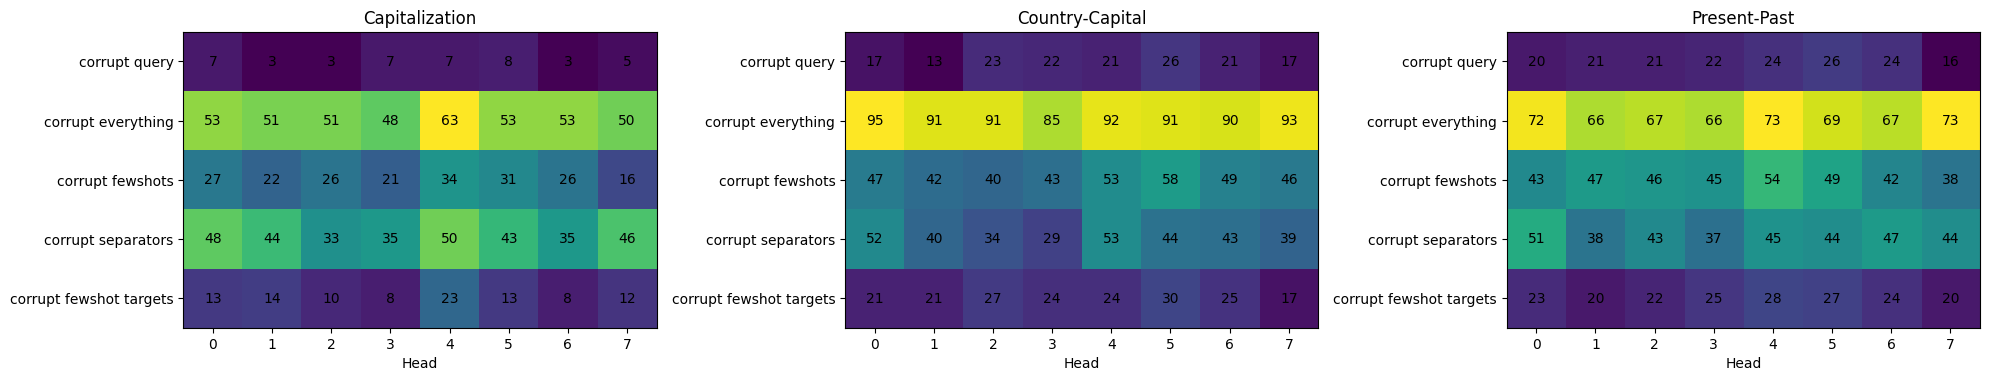

In [238]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3)
fig.set_size_inches((20, 5))
corrupted_example_to_label = {
    "corrupt_query" : "corrupt query",
    "corrupt_everything": "corrupt everything",
    "corrupt_both": "corrupt fewshots",
    "corrupt_sep": "corrupt separators",
    "separable_gemma": "corrupt fewshot targets"

}

for task_i, task in enumerate(tasks):
    axs[task_i].imshow(heads[task])
    axs[task_i].set_xticks(np.arange(8), np.arange(8))
    axs[task_i].set_yticks(np.arange(len(corrupted_examples)), [corrupted_example_to_label[ex] for ex in corrupted_examples])
    for i in range(len(corrupted_examples)):
        for j in range(8):
            text = axs[task_i].text(j, i, heads[task][i, j],
                        ha="center", va="center", color="black")
    # axs[task_i].tick_params(axis='x', rotation=45)
    axs[task_i].set_title("-".join([word.capitalize() for word in task.split("_")]))
    axs[task_i].set_xlabel("Head")
fig.tight_layout()
# plt.savefig("images/heads_by_head.png")

In [261]:
for task_i, task in enumerate(tasks):
    all_heads = set()
    for i, corrupted_example in enumerate(corrupted_examples):
        if corrupted_example == "corrupt_everything":
            continue
        all_heads = all_heads.union(heads_in_imp_heads_subset[((task, corrupted_example), threses_with_good_acc[(task, corrupted_example)])])
    print(task,
          len(heads_in_imp_heads_subset[((task, "corrupt_everything"), threses_with_good_acc[(task, "corrupt_everything")])] - all_heads)/len(heads_in_imp_heads_subset[((task, "corrupt_everything"), threses_with_good_acc[(task, "corrupt_everything")])]))

capitalization 0.13744075829383887
country_capital 0.3118131868131868
present_past 0.16455696202531644
